### Import Dependencies

In [28]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split 
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope
import seaborn as sns

### Load Data + Analysis

In [2]:
path = "Data/student-por.csv"
predict = "G3"

data_df = pd.read_csv(path, sep=";")
data_df.head(5)

data_df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

In [3]:
data_df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

### Data Manipulation

In [5]:
X = data_df.drop(['G3'], axis=1).copy()
X.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,4,3,4,1,1,3,4,0,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,no,5,3,3,1,1,3,2,9,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,no,4,3,2,2,3,3,6,12,13
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,3,2,2,1,1,5,0,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,4,3,2,1,2,5,0,11,13


In [6]:
y = data_df['G3'].copy()
y.head()

0    11
1    11
2    12
3    14
4    13
Name: G3, dtype: int64

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [8]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
112,16,2,2,1,2,1,3,1,2,1,...,False,True,False,True,False,True,False,True,True,False
19,16,4,3,1,1,0,3,1,3,1,...,False,True,False,True,False,True,False,True,True,False
630,18,4,4,2,3,0,5,4,4,1,...,True,False,False,True,False,True,False,True,True,False
584,17,0,0,2,1,0,4,4,3,1,...,True,False,False,True,False,True,False,True,True,False
610,19,1,1,2,2,3,3,5,4,1,...,False,True,False,True,True,False,True,False,False,True


### XGBoost model + Hyperparameter Tuning

In [9]:
space = {
    "max_depth": scope.int(hp.quniform("max_depth", 1, 50, 1)),
    "gamma": hp.uniform("gamma", 0, 1),
    "reg_alpha": hp.uniform("reg_alpha", 0, 50),
    "reg_lambda": hp.uniform("reg_lambda", 10, 100),
    "colsample_bytree": hp.uniform("colsample_bytree", 0, 1),
    "min_child_weight": hp.uniform("min_child_weight", 0, 5),
    "n_estimators": scope.int(hp.quniform("n_estimators", 100, 100000, 100)),
    "learning_rate": hp.uniform("learning_rate", 0, 0.15),
    "device": "cuda",
    "random_state": 32,
    "max_bin": scope.int(hp.quniform("max_bin", 200, 550, 1)),
    "eval_metric": "rmse",
    "early_stopping_rounds": 100,
}

In [10]:
def hyperparameter_tuning(space):
    model = xgb.XGBRegressor(**space)
    evaluation = [(X_train, y_train), (X_test, y_test)]

    model.fit(
        X_train,
        y_train,
        eval_set=evaluation,
        verbose=False,
    )

    pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, pred)
    print("SCORE:", rmse)

    # Specify what the loss is for each model.
    return {"loss": rmse, "status": STATUS_OK, "model": model}

In [11]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning, space=space, algo=tpe.suggest, max_evals=30, trials=trials)

print(best)

SCORE:                                                
0.8134061163489105                                    
  3%|▎         | 1/30 [00:04<02:03,  4.27s/trial, best loss: 0.8134061163489105]

/home/aryagill/miniconda3/envs/MLAI/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [01:26:35] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)



SCORE:                                                                          
0.8422302536088515                                                              
SCORE:                                                                          
0.8284057624691091                                                              
SCORE:                                                                          
0.9071098896995715                                                              
SCORE:                                                                          
0.8431543683958537                                                              
SCORE:                                                                          
0.8326258724042416                                                              
SCORE:                                                                          
0.9132251914781278                                                              
SCORE:                      

In [12]:
best_model = trials.results[np.argmin([r["loss"] for r in trials.results])]["model"]

print(best_model)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6241498575384716, device='cuda',
             early_stopping_rounds=100, enable_categorical=False,
             eval_metric='rmse', feature_types=None, gamma=0.8443132877592419,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.11257138063505043,
             max_bin=466, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=0.5397544742095867, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=61600,
             n_jobs=None, num_parallel_tree=None, random_state=32, ...)


In [13]:
xgb_preds_best = best_model.predict(X_test)
xgb_score_best = root_mean_squared_error(y_test, xgb_preds_best)
print("RMSE_Best_Model:", xgb_score_best)

# Best model yet: 0.7718455883249343

RMSE_Best_Model: 0.7718455883249343


### Tree Diagram

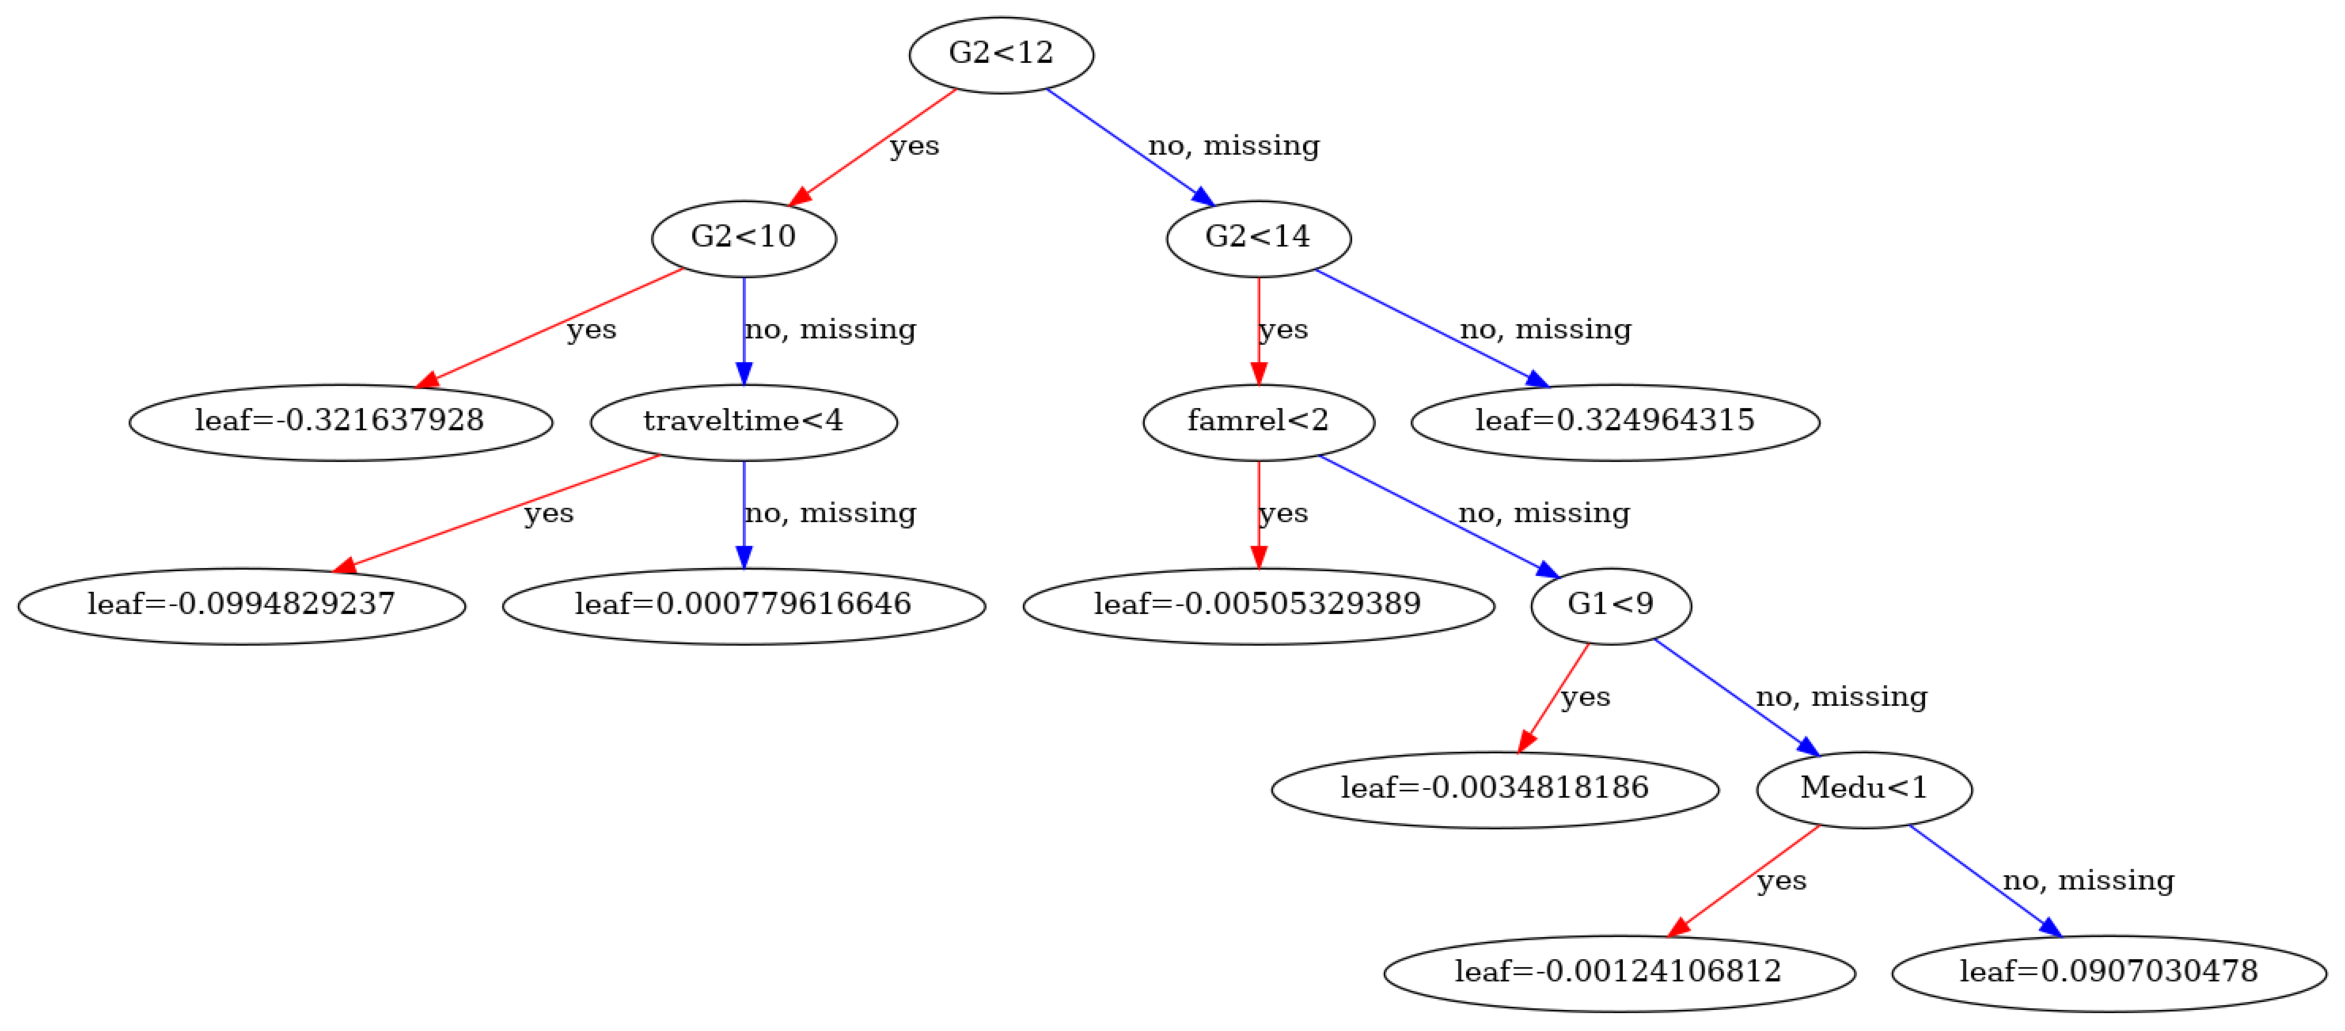

In [58]:
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(best_model, ax=ax)
plt.show()

### Top 10 Feature Importance

Text(0, 0.5, 'Features')

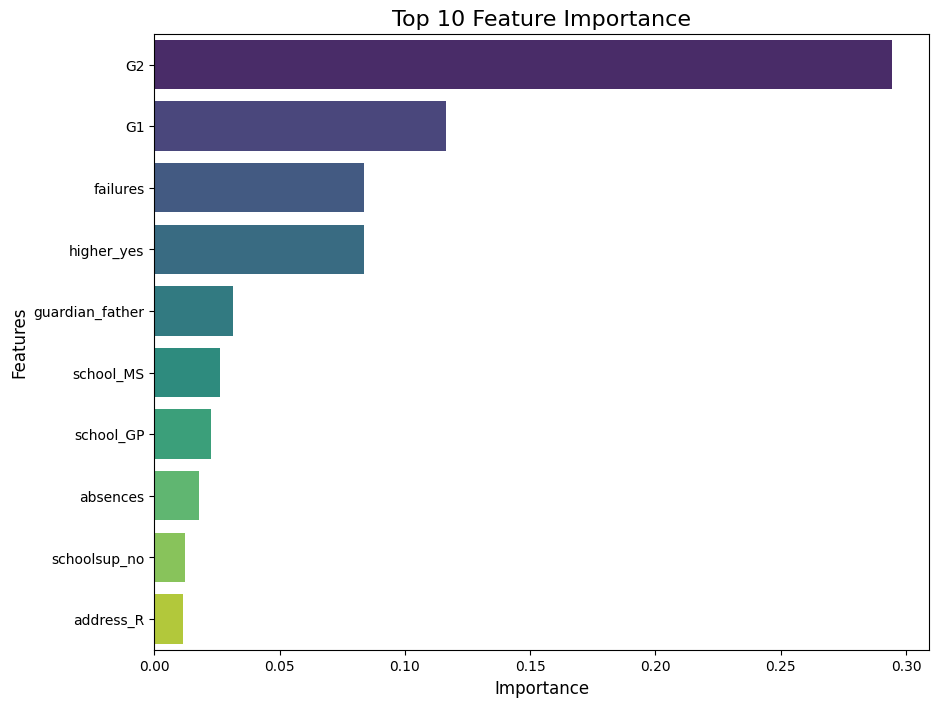

In [56]:
f1 = pd.DataFrame(data=best_model.feature_importances_, index=best_model.feature_names_in_, columns=['importance'])
f1_sorted = f1.sort_values('importance', ascending=False)
top_features = f1_sorted.head(10)

plt.figure(figsize=(10, 8))
sns.barplot(x=top_features['importance'], y=top_features.index, hue=top_features.index, data=top_features, palette='viridis', legend=False)
plt.title("Top 10 Feature Importance", fontsize=16)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)